###### Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Daniel Koehn based on Jupyter notebooks by Marc Spiegelman [Dynamical Systems APMA 4101](https://github.com/mspieg/dynamical-systems) and  Kyle Mandli from his course [Introduction to numerical methods](https://github.com/mandli/intro-numerical-methods), notebook style sheet by L.A. Barba, N.C. Clementi [Engineering Computations](https://github.com/engineersCode)

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Simplified Convection Problem: The Lorenz Equations

The Lorenz Equations are a 3-D dynamical system that is a simplified model of Rayleigh-Benard thermal convection.  They are derived and described in detail in Edward Lorenz' 1963 paper [Deterministic Nonperiodic Flow](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0469%281963%29020%3C0130%3ADNF%3E2.0.CO%3B2)  in the Journal of Atmospheric Science. 

Here we will just sketch out the key points of the derivation.  A more complete derivation can be found [here](https://www.math.uni-hamburg.de/home/lauterbach/scripts/seminar03/prill.pdf)

The key idea is that the Lorenz Equations result from a severely truncated spectral approximation to the 2-D equations for incompressible thermal convection in stream-function/vorticity form.  These equations govern the flow of a buouyant incompressible fluid with a temperature dependent density in a layer of depth $h$, that is heated from below and cooled from the top.  

## Governing Equations

The full coupled set of scaled PDE's describe the coupling of incompressible 2D Navier Stokes flow with an advection-diffusion equation for temperature, and can be written in dimensionless form as,

$$ 
   \frac{1}{\mathrm{Pr}}\left[ \frac{\partial \omega}{\partial t} + \vec{v}\cdot\nabla\omega\right] = \nabla^2\omega + \mathrm{Ra}\frac{\partial T}{\partial x}
$$
$$
    \nabla^2 \psi = -\omega
$$
$$ 
    \frac{\partial T}{\partial t} + \vec{v}\cdot\nabla T = \nabla^2 T
$$

where

$$
    \vec{v}=(u,0,w) = \nabla\times\psi\hat{j}=(-\frac{\partial\psi}{\partial z}, 0,  \frac{\partial\psi}{\partial x})
$$ 

is the fluid velocity field (which in this form is exactly incompressible with $\nabla\cdot\vec{v}=0$).  $\psi$ is the "Streamfunction"  whose contours are tangent to the fluid trajectories at all times.  The vorticity,

$$
    \omega = \bf{\vec{\omega} \cdot \hat{j}} = (\nabla\times\vec{v}) \cdot \hat{j}
$$ 

measures the local rate of rotation of the fluid, and is driven by horizontal variations in temperature (actually density). $\hat{j}=(0,1,0)^T$ denotes the unit vector in y-direction.  

Boundary conditions for temperature are $T=1$ on the bottom of the layer and $T=0$ on the top.  In the absence of any fluid motion ($\omega=\vec{v}=0$),  the temperature field is just a steady conductive ramp with 

$$ 
    T = 1 - z
$$

Thus we can also solve for the perturbation $\theta(x,z,t)$ away from this steady state by substituting

$$
    T = 1 - z + \theta(x,z,t)
$$

into the energy equation to solve for the perturbed temperature using

$$ 
    \frac{\partial \theta}{\partial t} + \vec{v}\cdot\nabla \theta = \nabla^2\theta + w
$$

### Parameters
In dimensionless form,  these equations have two important dimensionless numbers that control the structure and behavior of the convection.  

**The Prandtl Number**

The first is the "Prandtl Number", $\mathrm{Pr} = \frac{\nu}{\kappa}$  which is the ratio of the fluid viscosity $\nu$ to the thermal diffusivitiy $\kappa$.  Since both vorticity and temperature both obey advection diffusion equations (and viscosity acts to diffuse momentum/vorticity),  the Prandtl number is a measure of whether momemtum or energy is more dissipative.
  
**The Rayleigh Number**

The second key parameter is the Rayleigh number 

$$
    \mathrm{Ra} = \frac{g\alpha(T_1 - T_0)h^3}{\nu\kappa}
$$

which measures the balance of forces that drive convection (i.e. gravity, or temperature differences), to those that damp convection such as viscosity and thermal diffusivity.  Systems with large Rayleigh numbers are prone to vigorous convection.  However, it was shown by Rayleigh, that there is a critical value of the Rayleigh Number $\mathrm{Ra}_c$ below which there is no convection.  This value depends on the size of the convection cell and boundary conditions for stress on the fluid,  however, for the simplest case of a layer with no-slip top and bottom boundary conditions and cell with aspect ratio  $a=h/L$ (with $h$ the layer depth and $L$ the width of the convection cell), then the critical Ra number is

$$
\mathrm{Ra}_c = \pi^4 (1 + a^2)^3/a^2
$$

which has a minimum value for $a_{min}^2=1/2$. 

In [2]:
# load libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
from pylab import rcParams
from matplotlib import rc

# define font size
FSize = 18
font = {'color':  'black',
        'weight': 'normal',
        'size': FSize}
mpl.rc('xtick', labelsize=FSize) 
mpl.rc('ytick', labelsize=FSize)

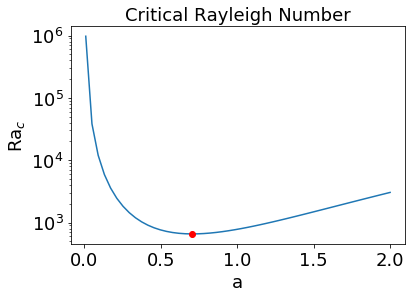

In [3]:
# Show Ra vs a
a = np.linspace(0.01,2.)
Rc = np.pi**4*(1. + a**2)**3/a**2
plt.figure()
plt.semilogy(a,Rc)
amin = np.sqrt(1./2.)
Rcmin = np.pi**4*(1. + amin**2)**3/amin**2
plt.semilogy(amin,Rcmin,'ro')
plt.xlabel('a', fontdict=font)
plt.ylabel('Ra$_c$', fontdict=font)
plt.title('Critical Rayleigh Number', fontdict=font)
plt.show()

## Spectral decomposition

Next, we expand the streamfunction and temperature fields in terms of a highly truncated Fourier Series where the streamfunction contains one cellular mode

$$
    \psi(x,z,t) = X(t)\sin(a\pi x)\sin(\pi z)
$$

and temperature has two modes

$$
    \theta(x,z,t) = Y(t)\cos(a\pi x)\sin(\pi z) - Z(t)\sin(2\pi z)
$$

Here, $X(t)$, $Y(t)$ and $Z(t)$ are the time dependent amplitudes of each mode. Defining

\begin{equation}
\begin{split}
\phi(x,z) &= \sin(a\pi x)\sin(\pi z)\\
\theta_0(x,z) &= \cos(a\pi x)\sin(\pi z)\\
\theta_1(z) &= -\sin(2\pi z)
\end{split}
\notag
\end{equation}

streamfunction and temperature fields simplify to:

\begin{equation}
\begin{split}
\psi(x,z,t) &= X(t) \phi(x,z)\\
\theta(x,z,t) &= Y(t) \theta_0(x,z) + Z(t) \theta_1(z)\\
\end{split}
\notag
\end{equation}

Using $a = a_{min} = \sqrt{0.5}$ for the minimum critical Rayleigh number $Ra_c^{min}$, the spatial components of each mode looks like

<Figure size 432x288 with 0 Axes>

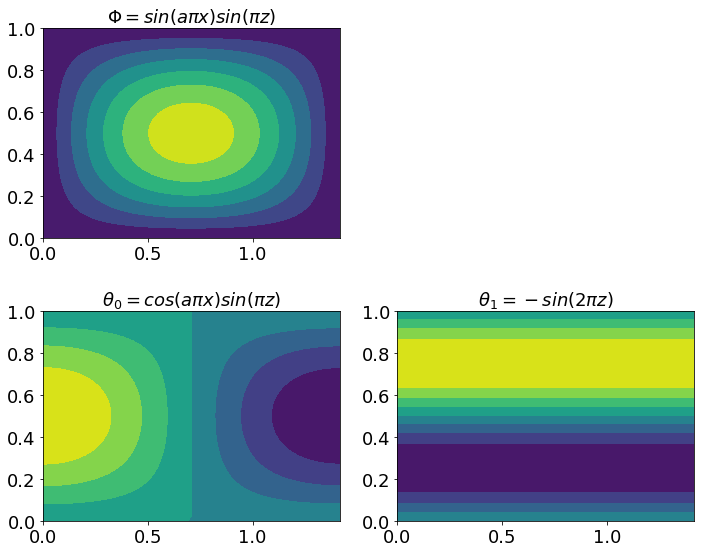

In [4]:
a = np.sqrt(0.5)
x0 = np.linspace(0,1./a)
z0 = np.linspace(0.,1.)
x,z = np.meshgrid(x0,z0)

psi = np.sin(a*np.pi*x)*np.sin(np.pi*z)
theta0 = np.cos(a*np.pi*x)*np.sin(np.pi*z)
theta1 = -np.sin(2.*np.pi*z)

plt.figure()
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.contourf(x,z,psi)
plt.title(r'$\Phi = sin(a \pi x)sin(\pi z)$', fontdict=font)
plt.gca().set_aspect('equal')

plt.subplot(2,2,3)
plt.contourf(x,z,theta0)
plt.title(r'$\theta_0 = cos(a \pi x)sin(\pi z)$', fontdict=font)
plt.gca().set_aspect('equal')

plt.subplot(2,2,4)
plt.contourf(x,z,theta1)
plt.title(r'$\theta_1 = -sin(2 \pi z)$', fontdict=font)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

For our initial conditions $X(0) = 2$, $Y(0) = 3$, $Z(0) = 4$, the streamfunction $\psi(x,z,t)$ and temperature field $\theta(x,z,t)$

\begin{equation}
\begin{split}
\psi(x,z,t) &= X(t)\sin(a\pi x)\sin(\pi z)\\
\theta(x,z,t) & = Y(t)\cos(a\pi x)\sin(\pi z) - Z(t)\sin(2\pi z)\\
\end{split}
\notag
\end{equation}

become 

\begin{equation}
\begin{split}
\psi(x,z,0) &= 2\sin(a\pi x)\sin(\pi z)\\
\theta(x,z,0) &= 3\cos(a\pi x)\sin(\pi z) - 4\sin(2\pi z)\\
\end{split}
\notag
\end{equation}

<Figure size 432x288 with 0 Axes>

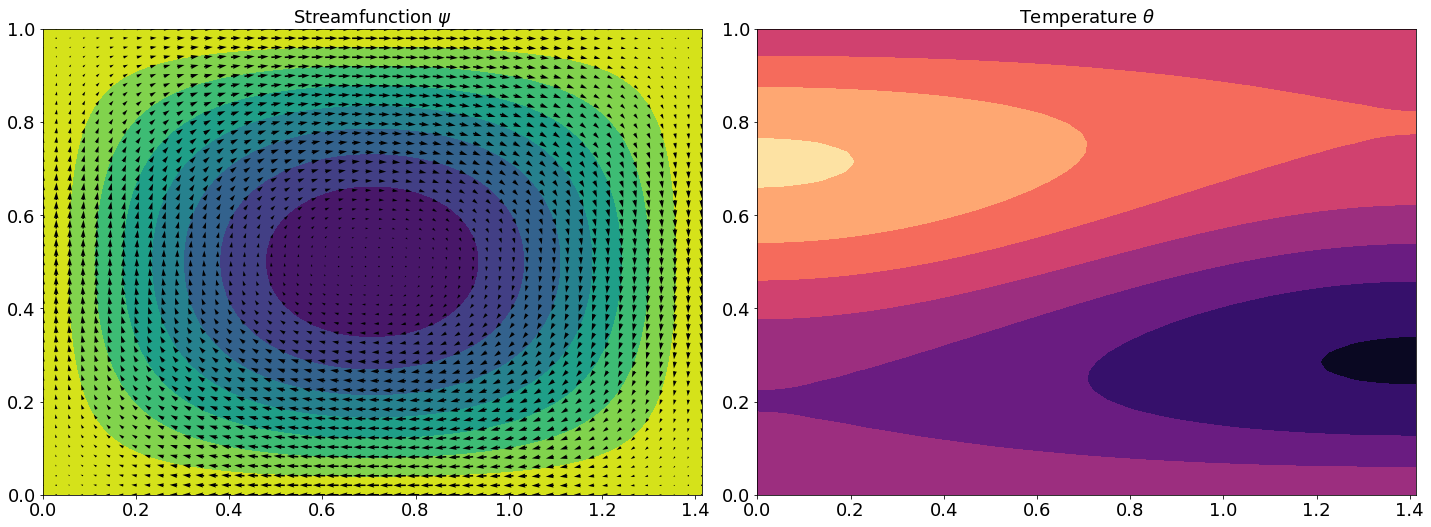

In [5]:
# Define figure size
plt.figure()
plt.figure(figsize=(20,20))

# Initial Streamfunction psi and velocity field
plt.subplot(1,2,1)
plt.contourf(x,z,2.*psi,cmap='viridis_r')

# Velocity field
U = - 2. * np.pi * np.sin(a*np.pi*x) * np.cos(np.pi*z)
V = 2. * a * np.pi * np.cos(a*np.pi*x) * np.sin(np.pi*z)
plt.quiver(x,z,U,V)
plt.gca().set_aspect('equal')
plt.title('Streamfunction $\psi$', fontdict=font)

# Initial temperature field 
plt.subplot(1,2,2)
plt.contourf(x,z,3*theta0 + 4*theta1,cmap='magma')
plt.gca().set_aspect('equal')
plt.title(r'Temperature $\theta$', fontdict=font)

plt.tight_layout()
plt.show()

## Lorenz equations

Inserting the spectral decomposition solutions into the momentum and energy conservation equations lead to the **Lorenz equations**

\begin{equation}
\begin{split}
\frac{\partial X}{\partial t} &= \sigma( Y - X)\\
\frac{\partial Y}{\partial t} &= rX - Y - XZ \\
\frac{\partial Z}{\partial t} &= XY -b Z
\end{split}
\notag
\end{equation}

where $\sigma$ denotes the "Prandtl number",  $r = \mathrm{Ra}/\mathrm{Ra}_c$ is a scaled "Rayleigh number" and $b$ is a parameter that is related to the the aspect ratio of a convecting cell in the original derivation.

## What we learned:

- The basic concept of the Lorenz equations to approximate the governing equations for thermal convection, described by the incompressible 2D Navier Stokes flow with an advection-diffusion equation for temperature.